## Compare variant calls: WGALN[bwasw/bcftools] vs GATK

In [1]:
%run ../../shared_setup.ipynb

The Cython magic has been move to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; Please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [2]:
wgaln_dir = '/data/plasmodium/pfalciparum/pf-crosses/data/reference/birren_2006'

In [3]:
!ls -lh {wgaln_dir}/bwasw/*

/data/plasmodium/pfalciparum/pf-crosses/data/reference/birren_2006/bwasw/3d7_7g8:
total 18M
-rw-rw-r-- 1 aliman aliman 579 Apr  8 16:36 3d7_7g8.log
-rw-rw-r-- 1 aliman aliman 18M Apr  8 16:36 3d7_7g8.sam

/data/plasmodium/pfalciparum/pf-crosses/data/reference/birren_2006/bwasw/3d7_dd2:
total 100M
-rw-rw-r-- 1 aliman aliman  580 Apr  8 16:37 3d7_dd2.log
-rw-rw-r-- 1 aliman aliman 100M Apr  8 16:37 3d7_dd2.sam

/data/plasmodium/pfalciparum/pf-crosses/data/reference/birren_2006/bwasw/3d7_hb3:
total 152M
-rw-rw-r-- 1 aliman aliman  29M Apr  9 08:47 3d7_hb3.bam
-rw-rw-r-- 1 aliman aliman  20K Apr  9 08:47 3d7_hb3.bam.bai
-rw-rw-r-- 1 aliman aliman   95 Apr  9 09:26 3d7_hb3.bam.samples
-rw-rw-r-- 1 aliman aliman 2.2M Apr  9 10:11 3d7_hb3.bcftools_m.vcf.gz
-rw-rw-r-- 1 aliman aliman  12K Apr  9 10:20 3d7_hb3.bcftools_m.vcf.gz.tbi
-rw-rw-r-- 1 aliman aliman 2.2M Apr  9 11:06 3d7_hb3.laat.vcf.gz
-rw-rw-r-- 1 aliman aliman  11K Apr  9 11:06 3d7_hb3.laat.vcf.gz.tbi
drwxrwxr-x 2 aliman aliman 4.0K

In [4]:
fasta_fn = '/data/plasmodium/pfalciparum/pf-crosses/data/genome/sanger/version3/September_2012/Pf3D7_v3.lookseq.fa'
genome = pyfasta.Fasta(fasta_fn)

In [5]:
method = 'bwasw'
alignment = '3d7_hb3'
sam_fn = os.path.join(wgaln_dir, method, alignment, '%s.sam' % alignment)
!ls -lh {sam_fn}
bam_fn = sam_fn[:-3] + 'bam'
!ls -lh {bam_fn}
laat_vcf_fn = bam_fn[:-3] + 'laat.vcf.gz'
!ls -lh {laat_vcf_fn}

-rw-rw-r-- 1 aliman aliman 119M Apr  8 16:36 /data/plasmodium/pfalciparum/pf-crosses/data/reference/birren_2006/bwasw/3d7_hb3/3d7_hb3.sam
-rw-rw-r-- 1 aliman aliman 29M Apr  9 08:47 /data/plasmodium/pfalciparum/pf-crosses/data/reference/birren_2006/bwasw/3d7_hb3/3d7_hb3.bam
-rw-rw-r-- 1 aliman aliman 2.2M Apr  9 11:06 /data/plasmodium/pfalciparum/pf-crosses/data/reference/birren_2006/bwasw/3d7_hb3/3d7_hb3.laat.vcf.gz


In [6]:
variants_wgaln = vcfnp.variants(laat_vcf_fn, 
                                fields=['CHROM', 'POS', 'REF', 'ALT'],
                                arities={'ALT': 1},
                                cache=True)
variants_wgaln

[vcfnp] 2015-04-10 10:38:21.219474 :: caching is enabled
[vcfnp] 2015-04-10 10:38:21.219908 :: cache file available
[vcfnp] 2015-04-10 10:38:21.220136 :: loading from cache file /data/plasmodium/pfalciparum/pf-crosses/data/reference/birren_2006/bwasw/3d7_hb3/3d7_hb3.laat.vcf.gz.vcfnp_cache/variants.npy


array([(b'Pf3D7_01_v3', 16425, b'C', b'A'),
       (b'Pf3D7_01_v3', 16428, b'A', b'C'),
       (b'Pf3D7_01_v3', 16429, b'C', b'A'), ...,
       (b'Pf3D7_14_v3', 3261240, b'A', b'C'),
       (b'Pf3D7_14_v3', 3261269, b'A', b'G'),
       (b'Pf3D7_14_v3', 3261373, b'A', b'C')], 
      dtype=[('CHROM', 'S12'), ('POS', '<i4'), ('REF', 'S12'), ('ALT', 'S12')])

In [7]:
callset_ngs = np.load('/data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.gatk.final.npz')
callset_ngs.keys()

['calldata', 'variants']

In [8]:
filter_pass_ngs = callset_ngs['variants']['FILTER_PASS']

In [9]:
genotype_ngs = vcfnp.view2d(callset_ngs['calldata'])['genotype']
genotype_ngs.shape

(191886, 21)

In [10]:
clone_is_alt_ngs = genotype_ngs[:, 1] == 1

In [11]:
nnz(filter_pass_ngs)

36598

In [12]:
nnz(clone_is_alt_ngs)

128393

In [13]:
nnz(filter_pass_ngs & clone_is_alt_ngs)

36558

In [15]:
# obtain variants
variants_ngs = callset_ngs['variants'][filter_pass_ngs & clone_is_alt_ngs]

In [16]:
tbl_regions_1b

0|region_chrom,1|region_start,2|region_stop,3|region_type,4|region_size
Pf3D7_01_v3,1,27336,SubtelomericRepeat,27336
Pf3D7_01_v3,27337,92900,SubtelomericHypervariable,65564
Pf3D7_01_v3,92901,457931,Core,365031
Pf3D7_01_v3,457932,460311,Centromere,2380
Pf3D7_01_v3,460312,575900,Core,115589


In [19]:
def tabulate_variants_ngs(chrom):
    tbl = (etl
        .fromarray(variants_ngs[variants_ngs['CHROM'] == chrom])
        .cut('CHROM', 'POS', 'REF', 'ALT')
        .convert(['CHROM', 'REF'], lambda v: str(v, 'ascii'))
        .convert('ALT', lambda v: str(v[0], 'ascii'))
        .addfield('svlen', lambda row: len(row.ALT) - len(row.REF))
        .addfield('vtype', lambda row: 'SNP' if row.svlen == 0 else 'DEL' if row.svlen < 0 else 'INS')
    )
    return tbl

In [20]:
tbl_variants_ngs = tabulate_variants_ngs(b'Pf3D7_01_v3')
tbl_variants_ngs.display(5)
tbl_variants_ngs.nrows()

0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|vtype
Pf3D7_01_v3,93901,AATATATATAT,A,-10,DEL
Pf3D7_01_v3,94590,T,TATAC,4,INS
Pf3D7_01_v3,94993,CATATAT,C,-6,DEL
Pf3D7_01_v3,95518,G,T,0,SNP
Pf3D7_01_v3,95621,T,A,0,SNP


1002

In [21]:
def tabulate_variants_wgaln(chrom):
    tbl = (etl
        .fromarray(variants_wgaln[variants_wgaln['CHROM'] == chrom])
        .convert(['CHROM', 'REF', 'ALT'], lambda v: str(v, 'ascii'))
        .intervalleftjoin(tbl_regions_1b, 
                          lkey='CHROM', rkey='region_chrom', 
                          lstart='POS', lstop='POS', 
                          rstart='region_start', rstop='region_stop',
                          include_stop=True)
        .eq('region_type', 'Core')
        .cutout(4, 5, 6, 7, 8)
        .addfield('svlen', lambda row: len(row.ALT) - len(row.REF))
        .addfield('vtype', lambda row: 'SNP' if row.svlen == 0 else 'DEL' if row.svlen < 0 else 'INS')
    )
    return tbl

In [22]:
tbl_variants_wgaln = tabulate_variants_wgaln(b'Pf3D7_01_v3')
tbl_variants_wgaln.display(5)
tbl_variants_wgaln.nrows()

0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|vtype
Pf3D7_01_v3,93901,AATATATATAT,A,-10,DEL
Pf3D7_01_v3,94590,T,TATAC,4,INS
Pf3D7_01_v3,94993,CATATAT,C,-6,DEL
Pf3D7_01_v3,95518,G,T,0,SNP
Pf3D7_01_v3,95621,T,A,0,SNP


12621

In [23]:
def common_prefix(a, b):
    if len(a) == len(b):
        return a == b
    elif len(a) > len(b):
        return a.startswith(b)
    else:
        return b.startswith(a)
    

def tabulate_variants_joined(chrom):
    cov_wgaln = pysamstats.load_coverage(bam_fn, chrom=str(chrom, 'ascii'), pad=True)
    tbl_variants_ngs = tabulate_variants_ngs(chrom)
    tbl_variants_wgaln = tabulate_variants_wgaln(chrom)
    tbl = (tbl_variants_ngs
        .outerjoin(tbl_variants_wgaln, key=('CHROM', 'POS'), lprefix='ngs_', rprefix='wgaln_')
        .rename({0: 'CHROM', 1: 'POS'})
        .addfield('false_positive_site', lambda row: (row.ngs_REF is not None) and (row.wgaln_REF is None))
        .addfield('false_negative_site', lambda row: (row.ngs_REF is None) and (row.wgaln_REF is not None))
        .addfield('true_positive_site', lambda row: (row.ngs_REF is not None) and (row.wgaln_REF is not None)) 
        .addfield('type_match', lambda row: ((row.ngs_vtype is not None) and (row.ngs_vtype == row.wgaln_vtype)))
        .addfield('allele_match', lambda row: (row.ngs_REF == row.wgaln_REF) and (row.ngs_ALT == row.wgaln_ALT)) 
        .addfield('prefix_match', lambda row: (row.type_match and common_prefix(row.ngs_ALT, row.wgaln_ALT) and common_prefix(row.ngs_REF, row.wgaln_REF)))
        .addfield('coverage_wgaln', lambda row: cov_wgaln.reads_all[row.POS - 1])
        .gt('coverage_wgaln', 0)
    )
    return tbl

In [24]:
tbl_variants_joined = tabulate_variants_joined(b'Pf3D7_01_v3')
def _tr_style(row):
    style = 'background-color: %s' % ('#0f0' if row.allele_match 
                                      else '#af0' if row.type_match
                                      else '#ff0' if row.true_positive_site
                                      else '#f44' if row.false_positive_site
                                      else '#44f' if row.false_negative_site
                                      else 'white')
    return style
tbl_variants_joined.display(100, tr_style=_tr_style)


0|CHROM,1|POS,2|ngs_REF,3|ngs_ALT,4|ngs_svlen,5|ngs_vtype,6|wgaln_REF,7|wgaln_ALT,8|wgaln_svlen,9|wgaln_vtype,10|false_positive_site,11|false_negative_site,12|true_positive_site,13|type_match,14|allele_match,15|prefix_match,16|coverage_wgaln
Pf3D7_01_v3,93901,AATATATATAT,A,-10,DEL,AATATATATAT,A,-10,DEL,False,False,True,True,True,True,1
Pf3D7_01_v3,94590,T,TATAC,4,INS,T,TATAC,4,INS,False,False,True,True,True,True,1
Pf3D7_01_v3,94993,CATATAT,C,-6,DEL,CATATAT,C,-6,DEL,False,False,True,True,True,True,1
Pf3D7_01_v3,95518,G,T,0,SNP,G,T,0,SNP,False,False,True,True,True,True,1
Pf3D7_01_v3,95621,T,A,0,SNP,T,A,0,SNP,False,False,True,True,True,True,1
Pf3D7_01_v3,95632,G,A,0,SNP,G,A,0,SNP,False,False,True,True,True,True,1
Pf3D7_01_v3,95641,G,A,0,SNP,G,A,0,SNP,False,False,True,True,True,True,1
Pf3D7_01_v3,95680,A,G,0,SNP,A,G,0,SNP,False,False,True,True,True,True,1
Pf3D7_01_v3,95685,G,T,0,SNP,G,T,0,SNP,False,False,True,True,True,True,1
Pf3D7_01_v3,95686,A,C,0,SNP,A,C,0,SNP,False,False,True,True,True,True,1


In [27]:
def plot_variant_density(variants, chrom, window=5000, ax=None):
    v = variants[variants['CHROM'] == chrom]
    seq = np.asarray(genome[str(chrom, 'ascii')])
    counts, windows = allel.stats.windowed_count(v['POS'], size=window, start=1, stop=seq.size)
    y = counts / window
    x = windows.mean(axis=1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 1))
        sns.despine(ax=ax, offset=5)
    ax.plot(x, y)
    ax.set_xlim(0, seq.size)

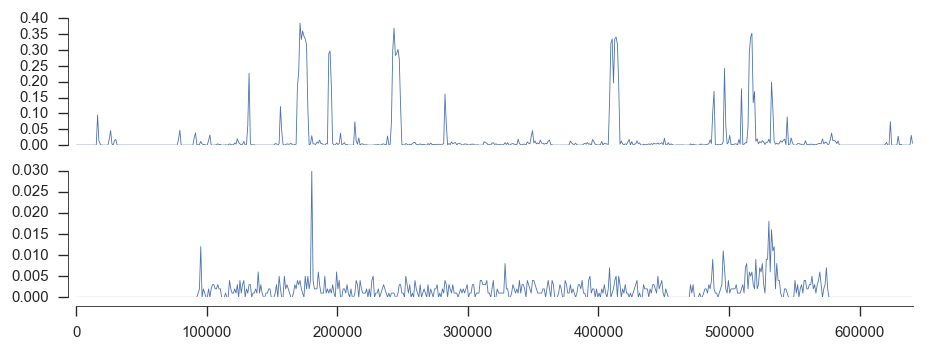

In [30]:
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(2, 1, 1)
sns.despine(ax=ax, bottom=True, offset=5)
plot_variant_density(variants_wgaln, b'Pf3D7_01_v3', window=1000, ax=ax)
ax.set_xticks([])
ax = fig.add_subplot(2, 1, 2)
sns.despine(ax=ax, offset=5)
plot_variant_density(variants_ngs, b'Pf3D7_01_v3', window=1000, ax=ax)

In [36]:
def eval_performance(chrom, window=1000):
    tbl_variants_joined = tabulate_variants_joined(chrom)
    df = tbl_variants_joined.cut('POS', 'ngs_vtype', 'wgaln_vtype', 'false_positive_site', 'false_negative_site', 'true_positive_site', 'type_match', 'allele_match', 'prefix_match').todataframe()
    is_snp = (df.ngs_vtype == 'SNP')
    is_indel = (df.ngs_vtype == 'INS') | (df.ngs_vtype == 'DEL')
    pos = df.POS
    seq = np.asarray(genome[str(chrom, 'ascii')])

    # plot site FDR
    pos_site_fp = pos[df.false_positive_site]
    pos_site_tp = pos[df.true_positive_site]
    counts_fp, windows = allel.stats.windowed_count(pos_site_fp, size=window, start=1, stop=seq.size)
    counts_tp, _ = allel.stats.windowed_count(pos_site_tp, size=window, start=1, stop=seq.size)
    windowed_fdr = counts_fp / (counts_fp + counts_tp)    
    fig, ax = plt.subplots(figsize=(9, 1))
    sns.despine(ax=ax, offset=5)
    x = windows.mean(axis=1)
    y = windowed_fdr
    ax.plot(x, y, lw=1)
    ax.set_xlim(1, seq.size)
    ax.set_ylabel('FDR')
    ax.set_title('site FDR')
    ax.set_xlabel(str(chrom, 'ascii'))
    
    # plot site sensitivity
    pos_site_fn = pos[df.false_negative_site]
    counts_fn, _ = allel.stats.windowed_count(pos_site_fn, size=window, start=1, stop=seq.size)
    windowed_sensitivity = counts_tp / (counts_tp + counts_fn)
    fig, ax = plt.subplots(figsize=(9, 1))
    sns.despine(ax=ax, offset=5)
    x = windows.mean(axis=1)
    y = windowed_sensitivity
    ax.plot(x, y, lw=1)
    ax.set_xlim(1, seq.size)
    ax.set_ylabel('sensitivity')
    ax.set_title('site sensitivity')
    ax.set_xlabel(str(chrom, 'ascii'))
    
    # site FDR, defined as #sites only discovered by NGS / total #sites discovered by NGS
    n_site_fp = nnz(df.false_positive_site)
    n_site_tp = nnz(df.true_positive_site)
    fdr_site = n_site_fp / (n_site_fp + n_site_tp)
    print('site FDR', fdr_site)
    
    # site sensitivity, defined as #sites discovered by both NGS and wgaln / total #sites discovered by wgaln
    n_site_fn = nnz(df.false_negative_site)
    sensitivity_site = n_site_tp / (n_site_tp + n_site_fn)
    print('site sensitivity', sensitivity_site)

    # SNP FDR, defined as #SNPs only discovered by NGS / total #SNPs discovered by NGS
    n_snp_fp = nnz(is_snp & ~df.allele_match)
    n_snp_tp = nnz(is_snp & df.allele_match)
    fdr_snp = n_snp_fp / (n_snp_fp + n_snp_tp)
    print('SNP FDR', fdr_snp)
    
    # SNP sensitivity, defined as #SNPs discovered by both NGS and wgaln / total #SNPs discovered by wgaln
    n_snp_fn = nnz((df.wgaln_vtype == 'SNP') & ~df.allele_match)
    log('SNP FP', n_snp_fp, 'TP', n_snp_tp, 'FN', n_snp_fn)
    sensitivity_snp = n_snp_tp / (n_snp_tp + n_snp_fn)
    print('SNP sensitivity', sensitivity_snp)

    # INDEL FDR, defined as #INDELs only discovered by NGS / total #INDELs discovered by NGS
    n_indel_fp = nnz(is_indel & ~df.prefix_match)
    n_indel_tp = nnz(is_indel & df.prefix_match)
    fdr_indel = n_indel_fp / (n_indel_fp + n_indel_tp)
    print('INDEL FDR (prefix match)', fdr_indel)

    # INDEL sensitivity, defined as #INDELs discovered by both NGS and wgaln / total #INDELs discovered by wgaln
    is_indel_wgaln = (df.wgaln_vtype == 'INS') | (df.wgaln_vtype == 'DEL')
    n_indel_fn = nnz(is_indel_wgaln & ~df.prefix_match)
    log('INDEL FP', n_indel_fp, 'TP', n_indel_tp, 'FN', n_indel_fn)
    sensitivity_indel = n_indel_tp / (n_indel_tp + n_indel_fn)
    print('INDEL sensitivity (prefix match)', sensitivity_indel)

    # INDEL FDR, defined as #INDELs only discovered by NGS / total #INDELs discovered by NGS
    n_indel_fp = nnz(is_indel & ~df.allele_match)
    n_indel_tp = nnz(is_indel & df.allele_match)
    fdr_indel = n_indel_fp / (n_indel_fp + n_indel_tp)
    print('INDEL FDR (allele match)', fdr_indel)

    # INDEL sensitivity, defined as #INDELs discovered by both NGS and wgaln / total #INDELs discovered by wgaln
    is_indel_wgaln = (df.wgaln_vtype == 'INS') | (df.wgaln_vtype == 'DEL')
    n_indel_fn = nnz(is_indel_wgaln & ~df.allele_match)
    log('INDEL FP', n_indel_fp, 'TP', n_indel_tp, 'FN', n_indel_fn)
    sensitivity_indel = n_indel_tp / (n_indel_tp + n_indel_fn)
    print('INDEL sensitivity (allele match)', sensitivity_indel)


2015-04-10 10:44:18.987989 :: SNP FP 56 TP 282 FN 11802
2015-04-10 10:44:18.993326 :: INDEL FP 193 TP 336 FN 201
2015-04-10 10:44:18.998826 :: INDEL FP 257 TP 272 FN 265


site FDR 0.2364475201845444
site sensitivity 0.05245226210284447
SNP FDR 0.16568047337278108
SNP sensitivity 0.02333664349553128
INDEL FDR (prefix match) 0.3648393194706994
INDEL sensitivity (prefix match) 0.6256983240223464
INDEL FDR (allele match) 0.48582230623818523
INDEL sensitivity (allele match) 0.5065176908752328


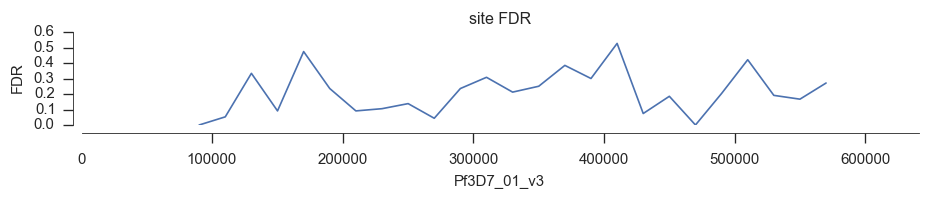

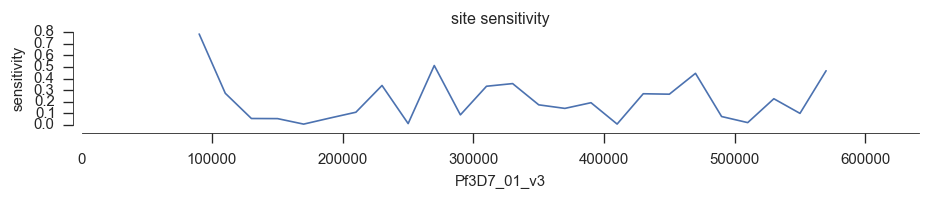

In [37]:
eval_performance(b'Pf3D7_01_v3', window=20000)

2015-04-10 10:44:49.474748 :: SNP FP 115 TP 1133 FN 67046
2015-04-10 10:44:49.491960 :: INDEL FP 800 TP 2038 FN 1027
2015-04-10 10:44:49.504404 :: INDEL FP 1169 TP 1669 FN 1396


site FDR 0.1860009789525208
site sensitivity 0.0466846330919095
SNP FDR 0.0921474358974359
SNP sensitivity 0.016618020211502077
INDEL FDR (prefix match) 0.28188865398167723
INDEL sensitivity (prefix match) 0.664926590538336
INDEL FDR (allele match) 0.4119097956307259
INDEL sensitivity (allele match) 0.5445350734094616


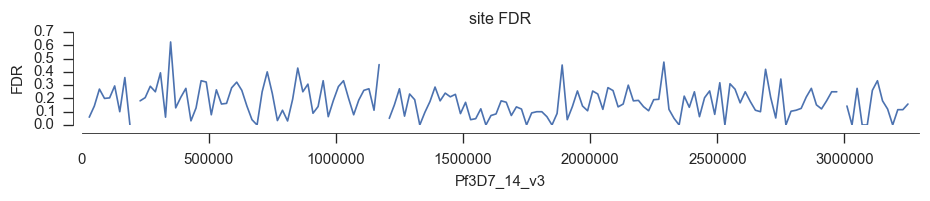

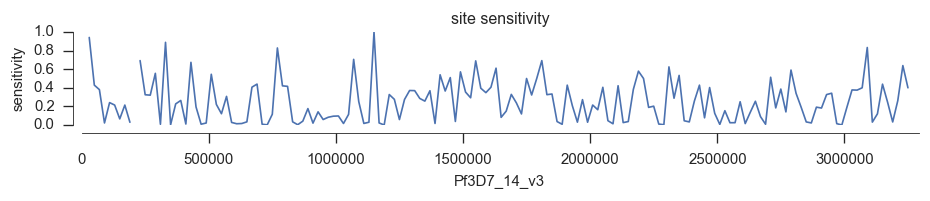

In [38]:
eval_performance(b'Pf3D7_14_v3', window=20000)